Importing Data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Dataset_stage/data.zip

Archive:  gdrive/My Drive/Dataset_stage/data.zip
   creating: data/
   creating: data/CIMA/
  inflating: data/CIMA/patiente10.dcm  
  inflating: data/CIMA/patiente10_1.dcm  
  inflating: data/CIMA/patiente10_2.dcm  
  inflating: data/CIMA/patiente10_3.dcm  
  inflating: data/CIMA/patiente11.dcm  
  inflating: data/CIMA/patiente11_1.dcm  
  inflating: data/CIMA/patiente11_2.dcm  
  inflating: data/CIMA/patiente11_3.dcm  
  inflating: data/CIMA/patiente11_4.dcm  
  inflating: data/CIMA/patiente11_5.dcm  
  inflating: data/CIMA/patiente12.dcm  
  inflating: data/CIMA/patiente12_1.dcm  
  inflating: data/CIMA/patiente12_2.dcm  
  inflating: data/CIMA/patiente12_3.dcm  
  inflating: data/CIMA/patiente12_4.dcm  
  inflating: data/CIMA/patiente12_5.dcm  
  inflating: data/CIMA/patiente13.dcm  
  inflating: data/CIMA/patiente13_1.dcm  
  inflating: data/CIMA/patiente13_2.dcm  
  inflating: data/CIMA/patiente14.dcm  
  inflating: data/CIMA/patiente14_1.dcm  
  inflating: data/CIMA/patiente14_2.

Installing packages

In [ ]:
!pip install pydicom
!pip install pypng

     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 48 kB 2.4 MB/s 


Importings packages


In [ ]:
  import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import numpy as np
from timeit import default_timer as timer
import cv2
import pandas as pd
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow import image
import png
import csv

Image Pre-Proccesing functions

In [ ]:
#Cropping boarders
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):

    nrows, ncols = img.shape

    # Get the start and end rows and columns
    l_crop = int(ncols * l)
    r_crop = int(ncols * (1 - r))
    u_crop = int(nrows * u)
    d_crop = int(nrows * (1 - d))

    cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    return cropped_img 

Preparing for the annotation's deletion ( For Dicom Files ) 


In [ ]:
def globalBinarise(img, thresh = 0.001, maxval = 1.0):

    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval

    return binarised_img

In [ ]:
def minMaxNormalise(img):

    norm_img = (img - img.min()) / (img.max() - img.min())

    return norm_img

In [ ]:
def editMask(mask, ksize=(23, 23), operation="open"):

    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)

    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)

    return edited_mask

In [ ]:
def sortContoursByArea(contours, reverse=True):

    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)

    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]

    return sorted_contours, bounding_boxes

In [ ]:
def xLargestBlobs(mask, top_x=1, reverse=True):

    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(
        image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE
    )

    n_contours = len(contours)

    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:

        # Make sure that the number of contours to keep is at most equal
        # to the number of contours present in the mask.
        if n_contours < top_x or top_x == None:
            top_x = n_contours

        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = sortContoursByArea(
            contours=contours, reverse=reverse
        )

        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_x]

        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)

        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(
            image=to_draw_on,  # Draw the contours on `to_draw_on`.
            contours=X_largest_contours,  # List of contours to draw.
            contourIdx=-1,  # Draw all contours in `contours`.
            color=1,  # Draw the contours in white.
            thickness=-1,  # Thickness of the contour lines.
        )

    return n_contours, X_largest_blobs

In [ ]:
def applyMask(img, mask):

    masked_img = img.copy()
    masked_img[mask == 0] = 0

    return masked_img

All Preprocessing function
Input : Dicom.pixel_array
Output : np.array

In [ ]:
def PreProc(img):
  img = minMaxNormalise(img)
  img=cropBorders(img)
  imgB = globalBinarise(img)
  imgB = editMask(imgB)
  N,imgBE = xLargestBlobs(imgB)
  final = applyMask(img,imgBE)
  return final 


Image Proccesing


In [ ]:
#Contrast stretching :
#Input/outpt : np.array
# X : contrast stretching parameter X must be between 0 and 1
def contrast_stretch_Alpha(img,x):
  Alpha = 5
  height,width = img.shape
  contrast_stretched_image = np.zeros((height,width))
  for row in range(0,height):
    for column in range(0,width):

      Pixel_Intensity = img[row,column]
      if (Pixel_Intensity < x):
        contrast_stretched_image[row,column] = x*((Pixel_Intensity/x)**Alpha)

      if (Pixel_Intensity >= x):
        contrast_stretched_image[row,column] = 1 - (x*(((1-Pixel_Intensity)/x)**Alpha))
  
  return contrast_stretched_image

  


In [ ]:
#This function eliminates low pixel intensity without touching micro calcification
# 0.29 is the selection parameter 
def clean(img):
  height,width = img.shape
  for col in range(height):
    for row in range(width):
      if ((img[col,row]<0.29 ) and (img[col,row]!=0) ):
        img[col,row]=0
  return img

In [ ]:
# I added this function because even after the first cropping some images
# contained some other useless elements 
# So i had to go throught every procceced image to do the work
# And in the CSV file I added a column 'Crop' that in order to determine 
# the cropping location
# HDL : Haut Droite Ligne
# BGC :  Bas Gauche Colonne

def crop_proc(img,cr):
  if (cr =='HDL') :
    crop = cropBorders(img,u=0.31,d=0.05,l=0.06, r=0.06)
  elif (cr == 'HDC'):
    crop = cropBorders(img,u=0.2,d=0.05,l=0.06, r=0.2)
  elif (cr == 'BDC'): 
    crop = cropBorders(img,u=0.01,d=0.01,l=0.1, r=0.04)
  elif (cr=='BGC') :
    crop = cropBorders(img,u=0.01,d=0.18,l=0.1, r=0.04)
  elif (cr == 'HGL'):
    crop = cropBorders(img,u=0.01,d=0.01,l=0.1, r=0.04)
  elif (cr == 'HGC') : 
    crop = cropBorders(img,u=0.01,d=0.01,l=0.2, r=0.04)
  elif (cr == 'BGL'):
    crop = cropBorders(img,u=0.01,d=0.1,l=0.04, r=0.04)

  return crop



In [ ]:
#All processing functions
#Input : np.array , cropp : In cas an extra cropping is needed
#Output : np.array 
def proc(img,cropp):
  img = minMaxNormalise(img)
  img = contrast_stretch_Alpha(img,0.99)
  img = clean(img)
  if (cropp!='N'):
    img = crop_proc(img,cropp)
  return img

Help functions


In [ ]:
#Taking a pandas data frame that contains all dicom files's directory 
# and adding that str to a list if that mamo contains MicroCalcif
def get_micro(pd):
  i=0
  L=[]
  for i in range(pd.shape[0]):
    if (pd.at[i,'micro']=='Y'):
      L.append(str(pd.loc[i,'chemin']))
  return L


In [ ]:
#This function takes a string (directory of the dicom file)
# and returns the patient number
def extrat_pat_nb(ch):
  chh=ch.split('/')[4]
  i=0
  Lint = ['0','1','2','3','4','5','6','7','8','9']
  for j in chh:
    if (j in Lint):
      break
    else:
      i+=1
  nb = chh[i:chh.find('.')]
  return nb


In [ ]:
#This functions saves the modification made on the dicom's pixel_array 
def saving_dicom(ds,newimg,ch):
  data = ds.pixel_array
  data_downsampling = newimg[::8, ::8]
  ds.PixelData = data_downsampling.tobytes()
  ds.Rows, ds.Columns = data_downsampling.shape
  ds.save_as(ch)

In [ ]:
#This functions checks if a image needs extrea cropping
def getextracrop(ch,pd):
  return pd.at[pd[pd['chemin']==ch].index[0],'crop']
  

In [ ]:
#This functions save a png file 
# img : np.array
def savepng(img,ch):
  cv2.imwrite(ch, img)

In [ ]:
#This function extracts the patient number
def pat(ch):
  i=0
  Lint = ['0','1','2','3','4','5','6','7','8','9']
  for j in ch:
    if (j in Lint):
      break
    else:
      i+=1
  x = ch.find('Proc') or ch.find('aug')
  nb = ch[i:x]
  return nb



In [ ]:
#This function finds the bbox's cordinates of the whole compound of miro calcif
def findbbox(ch):
  img = cv2.imread(ch)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea)
  S=0
  c = contours[-1]

  rect = cv2.boundingRect(c)

  x,y,w,h = rect
  x= x-500
  y = y -500
  w = w + 1500
  h = h+800
  cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),2)

  return x,y,w,h

Data augmentation


In [ ]:
#Adding a new directory of augmented data to the final csv
#x1,y1,x2,y2 are the bbox cordinates
def addtocsv(pdd,ch):
  x1,y1,x2,y2 = findbbox(ch)
  pdd = pdd.append({'filepath' :ch,'x1':x1,'y1':y1,'x2':x2,'y2':y2,'class_name':'micro' }, ignore_index=True)
  return pdd


In [ ]:
def FlipH(img):
  flipped_img = np.fliplr(img)
  return flipped_img

In [ ]:
#This functions takes a csv file to a txt file for training
def csvtotxt(csv_file,txt_file):
  with open(txt_file, "w") as my_output_file:
      with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(",".join(row)+'\n') for row in csv.reader(my_input_file)]
  my_output_file.close()

In [ ]:
def FlipV(img):
  flipped = np.flipud(img)
  return flipped

In [ ]:
def rotate(img,c,F,csv):
  L =  [0,30,60,90,120,150,180,210,240,270,300,330]
  for i in L:
    rot = ndimage.rotate(img, i)
    if (F == 'H'):
      ch = '/content/aug/' + 'img' + pat(c) +'augH'+str(i) + '.png'
    elif (F=='V'):
      ch = '/content/aug/' + 'img' + pat(c) +'augV'+str(i) + '.png'
    elif (F=='VH'):
      ch = '/content/aug/' + 'img' + pat(c) +'augVH'+str(i) + '.png'
    else : 
      ch = '/content/aug/' + 'img' + pat(c) +'aug'+str(i) + '.png'
    savepng(rot,ch)
    csv = addtocsv(csv,ch)
    print('done',ch)
  return csv

In [ ]:
def augment(img,ch,csv):
  o = rotate(img,ch,'O',csv)

  FlippedH = FlipH(img)
  H = rotate(FlippedH,ch,'H',o)
  
  FlippedV = FlipV(img)
  V = rotate(FlippedV,ch,'V',H)

  FlippedVH = FlipH(FlippedV)
  VH = rotate(FlippedVH,ch,'VH',V)

  return VH



Main

In [ ]:
#Input dataframe of dicom files
data = pd.read_csv('/content/dicom.csv')
L = get_micro(data)
Lproc = []
for i in L:
  img = dcmread(i).pixel_array
  img = PreProc(img)
  img= proc(img,getextracrop(i,data))
  ch = '/content/Proc/' 'img' + extrat_pat_nb(i) + 'Proc' + '.png'
  topng(img,ch)
  Lproc.append(ch)
  data = addtocsv(data,ch)
  print('done')


data.to_csv('newproc.csv')
print(len(Lproc))
for i in Lproc:
  print(i)

In [ ]:

for i in Lproc:

img = cv2.imread(i)
ncsv = augment(img,i,data)
data = addtocsv(data,i)
print('***************** image done',i)

data.to_csv('train.csv',index=False)

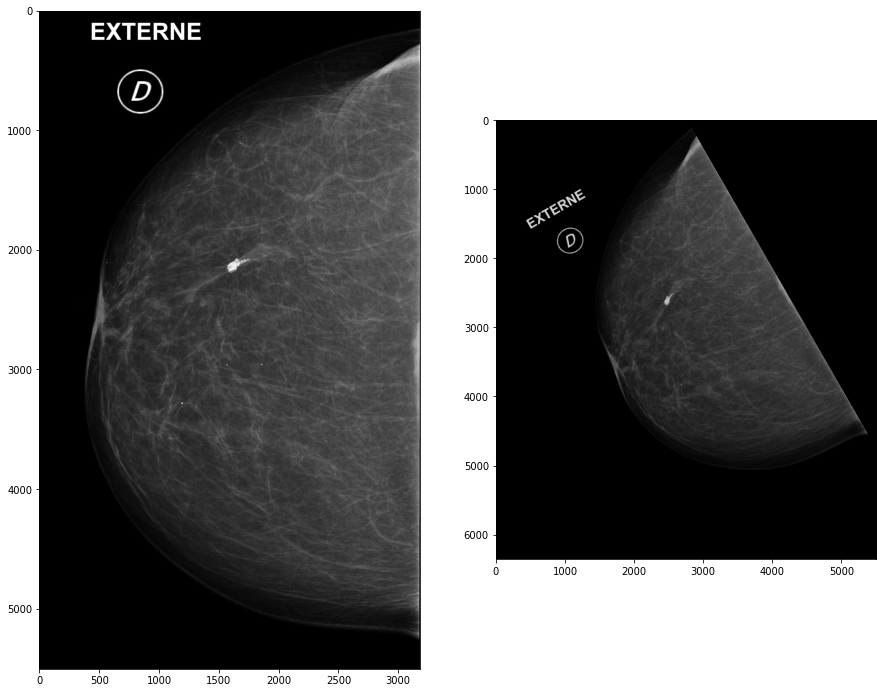

In [ ]:
img = dcmread('/content/patiente10.dcm').pixel_array

rot = ndimage.rotate(img, 30)

f,axes = plt.subplots(1,2,figsize=(15,15))
axes[0].imshow(img,plt.cm.gray)
axes[1].imshow(rot,plt.cm.gray)

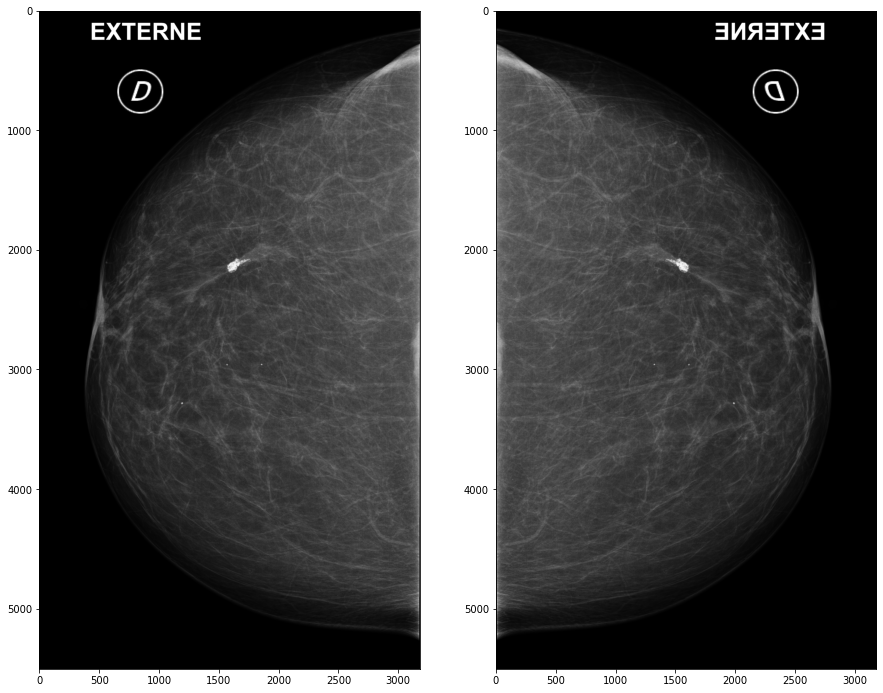

In [ ]:
img = dcmread('/content/patiente10.dcm').pixel_array

rot = FlipH(img)

f,axes = plt.subplots(1,2,figsize=(15,15))
axes[0].imshow(img,plt.cm.gray)
axes[1].imshow(rot,plt.cm.gray)